In [1]:
!pip install eli5 shap catboost

     |████████████████████████████████| 106 kB 8.3 MB/s 
     |████████████████████████████████| 564 kB 51.3 MB/s 
     |████████████████████████████████| 76.1 MB 1.4 MB/s 


In [2]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import datasets

# ML
from sklearn.svm import SVC, SVR
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

# ensemble(bagging)
from sklearn.ensemble import ( 
  BaggingClassifier, BaggingRegressor, RandomForestClassifier, RandomForestRegressor
)

#ensemble(boosting)
import xgboost as xgb
import lightgbm as lgb
import catboost as cb

#stacking
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import StackingClassifier, StackingRegressor

# 평가
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve, classification_report

# 교차검증
from sklearn.model_selection import (
  KFold, StratifiedKFold, RepeatedStratifiedKFold, cross_val_score, GridSearchCV, train_test_split
)

# Feature Selection
from sklearn.feature_selection import RFE, RFECV

# 시각화(SVM은 회귀계수가 나오지 않습니다.)
import eli5
from eli5.sklearn import PermutationImportance
import shap

# 트리 시각화
import graphviz

# 데이터 불균형

In [3]:
rawData = pd.read_csv('/content/drive/MyDrive/멀티캠퍼스/data/Fraud Detection/creditcard.csv')
rawData.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
rawData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

## EDA

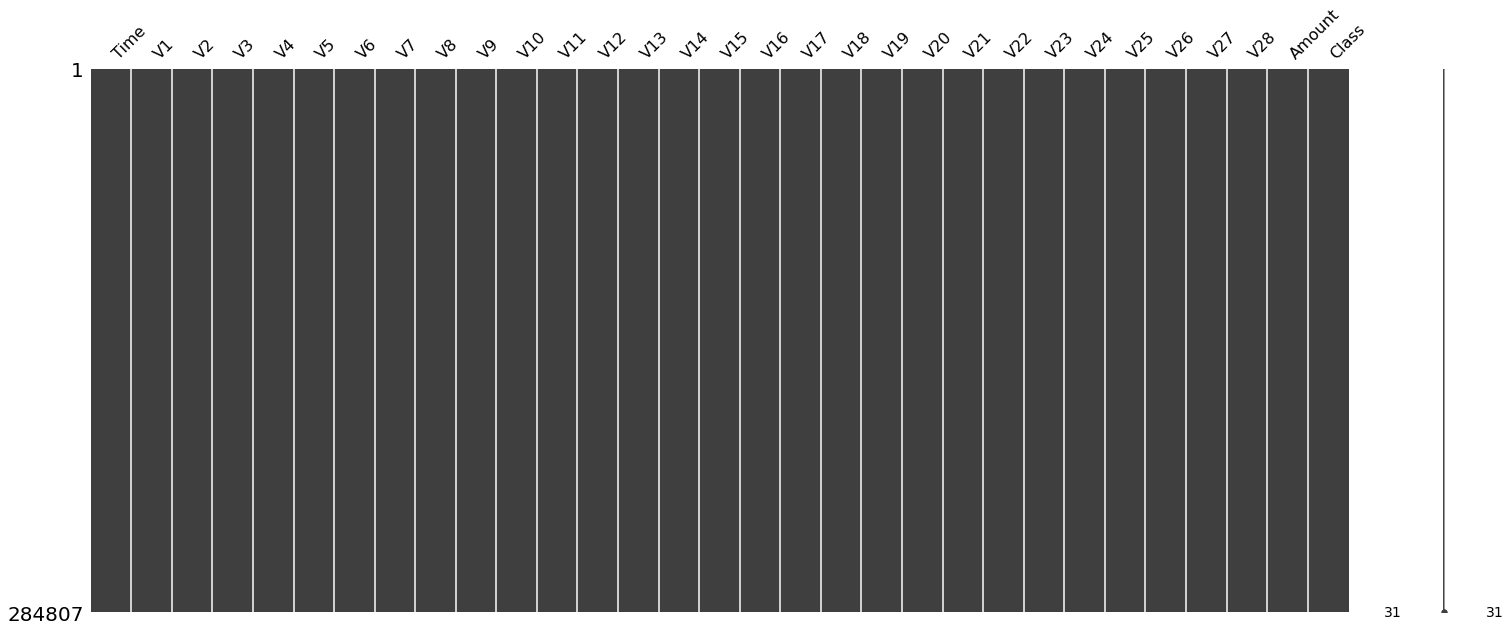

In [5]:
import missingno
missingno.matrix(rawData)
plt.show()

In [6]:
rawData.shape

(284807, 31)

- 자료에 대한 결측치는 보이지 않습니다.
- 전체 자료의 개수는 대략 28만개 정도, 변수의 개수는 총 30개 입니다.
  - 이 중에 하나만 제외 하고는 블라인드

In [8]:
rawData['Class'].unique()

array([0, 1])

In [7]:
rawData['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

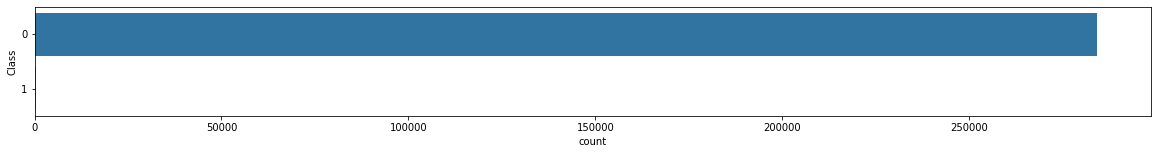

In [9]:
plt.figure(figsize=(20, 2))
sns.countplot(data=rawData, y='Class')
plt.show()

### 자료의 분포

In [10]:
def makeCorr(x, width=15, height=7):
  plt.figure( figsize=(width, height) )
  mask = np.zeros_like(x.corr(), dtype=np.bool)
  mask[np.triu_indices_from(mask)] = True
  sns.heatmap(x.corr(), annot=True, fmt='.2f', mask=mask, cmap='YlOrBr')
  plt.show()

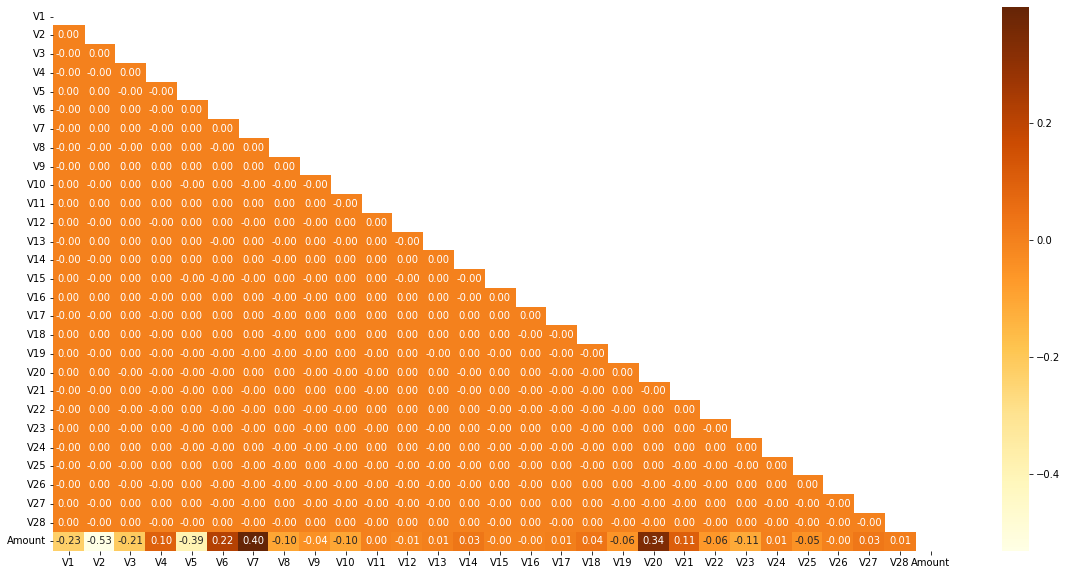

In [13]:
makeCorr(rawData.drop(columns=['Time', 'Class']), width=20, height=10)

- 전체적으로 자료들간의 상관관계는 거의 없는 것으로 보입니다

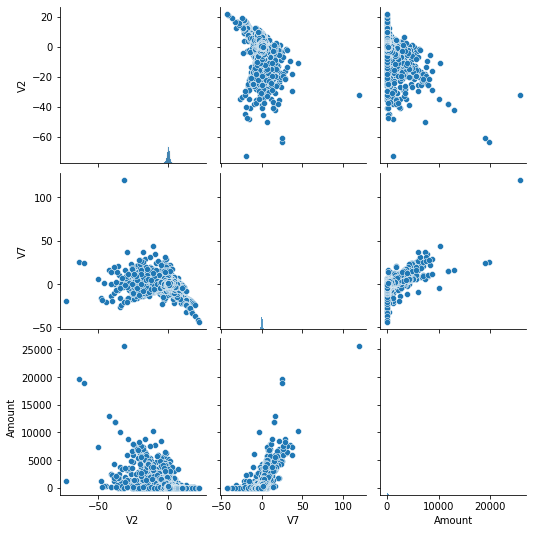

In [14]:
sns.pairplot(rawData[['V2', 'V7', 'Amount']])

In [15]:
# sns.pairplot(rawData.drop(columns=['Time', 'Class']))

Output hidden; open in https://colab.research.google.com to view.

### 자료의 관계 (Y에 미치는 영향)

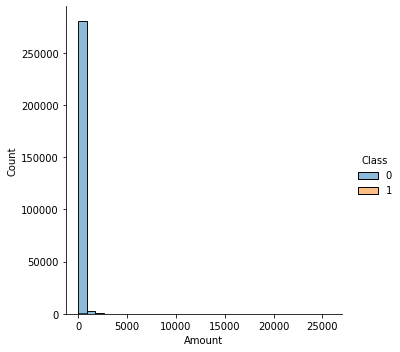

In [17]:
sns.displot(data=rawData, x='Amount', hue='Class', bins=30)

- 사기거래로 분류된 자료들이 너무 희박하기 때문에 잘 보이지 않음

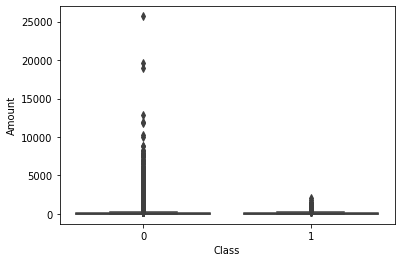

In [18]:
sns.boxplot(data=rawData, x='Class', y='Amount')

#### 1. 영향력이 클 것 같은 변수
- V3, V4, V9, V10, V11, V12, V14, V16, V17, V18

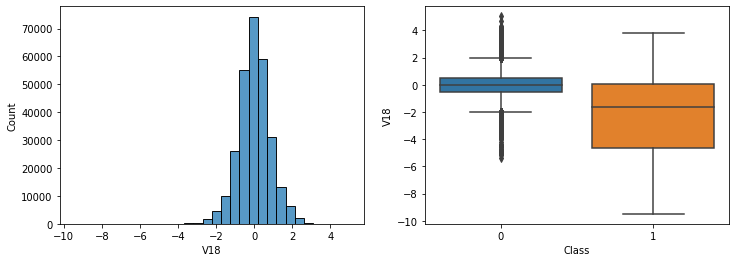

In [19]:
col_name = 'V18'
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
sns.histplot(data=rawData, x=col_name, bins=30, ax=ax[0])
sns.boxplot(data=rawData, x='Class', y=col_name, ax=ax[1])

#### 2. 영향력이 없는 것 같은 변수
- V6, V8, V13, V15, V20~ 28

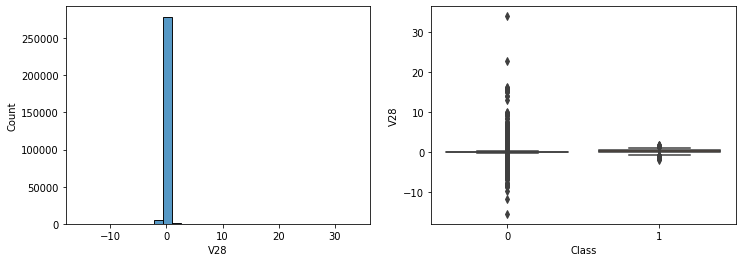

In [20]:
col_name = 'V28'
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
sns.histplot(data=rawData, x=col_name, bins=30, ax=ax[0])
sns.boxplot(data=rawData, x='Class', y=col_name, ax=ax[1])

## 모델링 1

### Base Model
- 일반화 선형모형 사용


In [22]:
x = rawData.drop(columns=['Time', 'Class'])
y = rawData['Class']

In [24]:
x_train, x_val, y_train, y_val = train_test_split(x, y, train_size=0.7, shuffle=True)

In [25]:
folds = StratifiedKFold(n_splits=10, shuffle=True)

In [29]:
model = LogisticRegression()

params = dict(
    penalty = ['elasticnet', 'none'], 
    C = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0],
    class_weight = ['balanced', None],
    solver = ['saga'],
    l1_ratio = [0.0, 0.3, 0.5, 0.8, 1.0]
)

In [ ]:
search = GridSearchCV( model, param_grid=params, cv=folds, scoring='roc_auc')
search.fit(x_train, y_train)

In [30]:
model = LogisticRegression().fit(x_train, y_train)

In [31]:
yhat_train = model.predict(x_train)
yhat_val = model.predict(x_val)

In [32]:
print(classification_report(y_train, yhat_train))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    199015
           1       0.87      0.63      0.73       349

    accuracy                           1.00    199364
   macro avg       0.93      0.81      0.86    199364
weighted avg       1.00      1.00      1.00    199364



In [33]:
print(classification_report(y_val, yhat_val))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85300
           1       0.82      0.68      0.74       143

    accuracy                           1.00     85443
   macro avg       0.91      0.84      0.87     85443
weighted avg       1.00      1.00      1.00     85443



## 샘플링
- 자료의 비율이 맞지 않는 경우
 1. 적은 클래스의 데이터를 많은 클래스에 맞춰서 늘리는 방법
 2. 많은 클래스의 데이터를 적은 클래스에 맞춰서 줄이는 방법

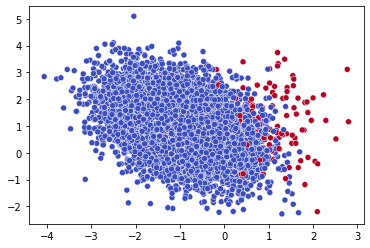

In [34]:
x, y = datasets.make_classification(
    n_samples = 10000, n_features= 2, random_state=20210723,
    n_redundant = 0, n_clusters_per_class=1, weights=[0.99], flip_y=0 
)

sns.scatterplot(x = x[:,0], y = x[:, 1], c=y, cmap='coolwarm')

In [35]:
np.unique(y, return_counts=True)

(array([0, 1]), array([9900,  100]))

### 오버샘플링
- 비율이 적은 클래스의 자료를 늘리는 방법

In [47]:
from imblearn.over_sampling import SMOTE, RandomOverSampler

In [48]:
sample = RandomOverSampler()
x_over_random, y_over_random = sample.fit_resample(x, y)
np.unique(y_over_random, return_counts=True)

(array([0, 1]), array([9900, 9900]))

**SMOTE**
![](https://imghub.insilicogen.com/media/photos/SMOTE_OPUxJ6w.png)
- KNN을 응용한 방법
   - 소수의 클래스 사이에 KNN을 이용해서 새로운 데이터를 생성

In [51]:
sample = SMOTE()
x_over_smote, y_over_smote = sample.fit_resample(x, y)
np.unique(y_over_smote, return_counts=True)

(array([0, 1]), array([9900, 9900]))

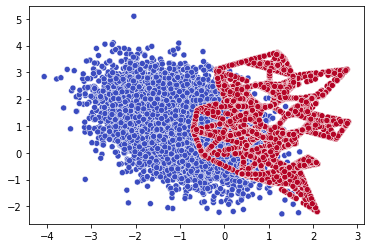

In [52]:
sns.scatterplot(x = x_over_smote[:,0], y = x_over_smote[:, 1], c=y_over_smote, cmap='coolwarm')

### 언더샘플링
- 다수의 클래스의 자료를 소수의 클래스에 맞춰서 줄이는 방법
- 랜덤하게 삭제
 - 의외로 효과가 좋음

In [40]:
from imblearn.under_sampling import *

In [41]:
sample = RandomUnderSampler()
x_under_random, y_under_random = sample.fit_resample(x, y)
np.unique(y_under_random, return_counts=True)

(array([0, 1]), array([100, 100]))

**토맥링크**
![](https://heung-bae-lee.github.io/image/what_is_tomeklinks_under_sampling.png)

- 다수의 클래스와 소수의 클래스가 가까이에 붙어 있으면 `토맥링크`라고 부릅니다. 
- 이 토맥링크들을 찾아서 다수의 자료를 줄이는 방법

In [42]:
sample = TomekLinks()
x_under_tomek, y_under_tomek = sample.fit_resample(x, y)
np.unique(y_under_tomek, return_counts=True)

(array([0, 1]), array([9872,  100]))

**CNN( Condensed Nearst Neighbor )**

![](https://amueller.github.io/COMS4995-s19/slides/aml-11-resampling-imbalanced-data/images/edited_condensed_nn.png)

- KNN을 응용한 방법
 - K를 1로 해서 이웃한 다수의 클래스를 찾아서 삭제

In [43]:
sample = CondensedNearestNeighbour()
x_under_cnn, y_under_cnn = sample.fit_resample(x, y)
np.unique(y_under_cnn, return_counts=True)

(array([0, 1]), array([179, 100]))

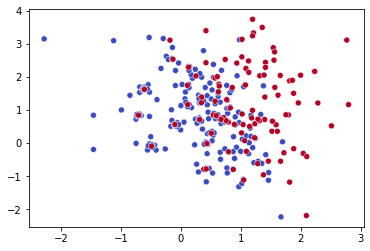

In [44]:
sns.scatterplot(x = x_under_cnn[:,0], y = x_under_cnn[:, 1], c=y_under_cnn, cmap='coolwarm')

**ENN(Edited Nearest Neighbors)**
- KNN을 응용한 방법
 - 소수의 클래스 주변의 다수의 클래스들을 먼저 제거

In [45]:
sample = EditedNearestNeighbours()
x_under_enn, y_under_enn = sample.fit_resample(x, y)
np.unique(y_under_enn, return_counts=True)

(array([0, 1]), array([9780,  100]))

**One sided selection**
- 토맥링크 + CNN

In [53]:
sample = OneSidedSelection()
x_under_tc, y_under_tc = sample.fit_resample(x, y)
np.unique(y_under_tc, return_counts=True)

(array([0, 1]), array([8436,  100]))

### 오버샘플링 + 언더샘플링
- 소수의 자료는 늘리고, 다수의 자료는 줄이는 방법을 동시에 수행

In [54]:
from imblearn.combine import *

**SMOTE + ENN**

In [57]:
sample = SMOTEENN()
x_smote_enn, y_smote_enn = sample.fit_resample(x, y)
np.unique(y_smote_enn, return_counts=True)

(array([0, 1]), array([9013, 9196]))

**SMOTE + Tomek**

In [58]:
sample = SMOTETomek()
x_smote_tomek, y_smote_tomek = sample.fit_resample(x, y)
np.unique(y_smote_tomek, return_counts=True)

(array([0, 1]), array([9730, 9730]))

### 전체 샘플링 방법 비교

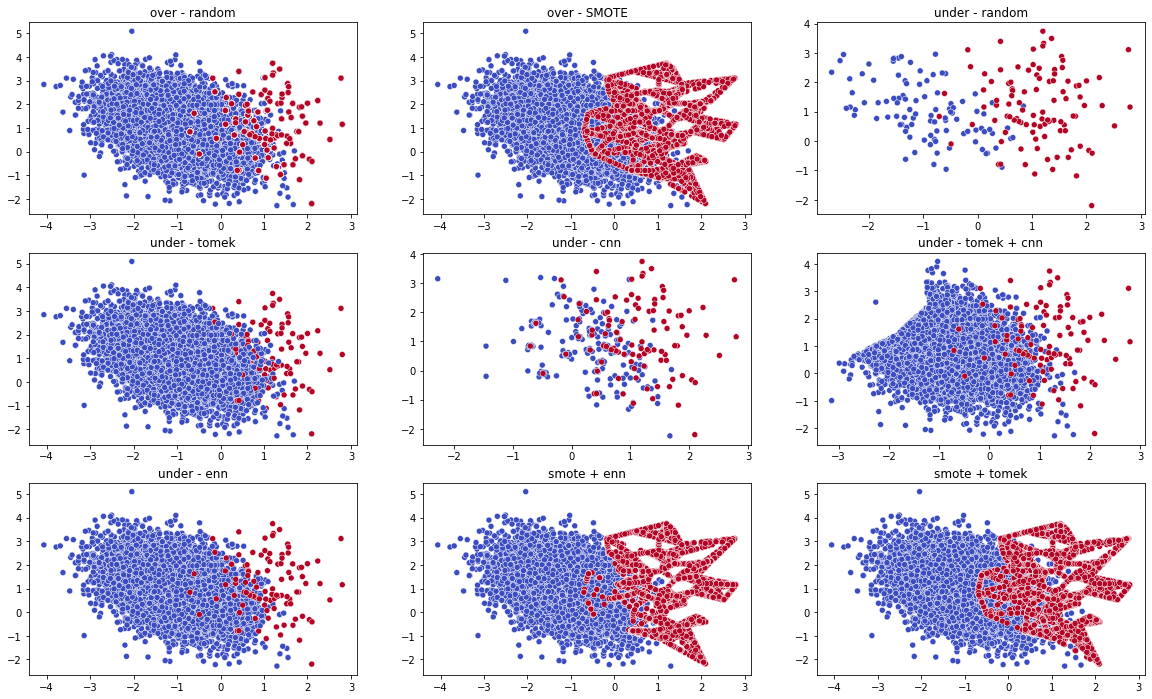

In [59]:
fig, ax = plt.subplots(3, 3, figsize=(20,12) )
ax[0,0].set_title('over - random')
sns.scatterplot(x = x_over_random[:,0], y = x_over_random[:, 1], c=y_over_random, cmap='coolwarm', ax=ax[0,0])
ax[0,1].set_title('over - SMOTE')
sns.scatterplot(x = x_over_smote[:,0], y = x_over_smote[:, 1], c=y_over_smote, cmap='coolwarm', ax=ax[0,1])
ax[0,2].set_title('under - random')
sns.scatterplot(x = x_under_random[:,0], y = x_under_random[:, 1], c=y_under_random, cmap='coolwarm', ax=ax[0,2])
ax[1,0].set_title('under - tomek')
sns.scatterplot(x = x_under_tomek[:,0], y = x_under_tomek[:, 1], c=y_under_tomek, cmap='coolwarm', ax=ax[1,0])
ax[1,1].set_title('under - cnn')
sns.scatterplot(x = x_under_cnn[:,0], y = x_under_cnn[:, 1], c=y_under_cnn, cmap='coolwarm', ax=ax[1,1])
ax[1,2].set_title('under - tomek + cnn')
sns.scatterplot(x = x_under_tc[:,0], y = x_under_tc[:, 1], c=y_under_tc, cmap='coolwarm', ax=ax[1,2])
ax[2,0].set_title('under - enn')
sns.scatterplot(x = x_under_enn[:,0], y = x_under_enn[:, 1], c=y_under_enn, cmap='coolwarm', ax=ax[2,0])
ax[2,1].set_title('smote + enn')
sns.scatterplot(x = x_smote_enn[:,0], y = x_smote_enn[:, 1], c=y_smote_enn, cmap='coolwarm', ax=ax[2,1])
ax[2,2].set_title('smote + tomek')
sns.scatterplot(x = x_smote_tomek[:,0], y = x_smote_tomek[:, 1], c=y_smote_tomek, cmap='coolwarm', ax=ax[2,2])
plt.show()

- 어떤 샘플링 방식이 더 좋을 지 알 수 없다
 - 자료의 형태에 따라서 달라질 수 있다
 - 불균형 자료에 대해 여러가지 방법을 시도하면서 비교

## 카드 사기거래 샘플링

### 오버샘플링
- SMOTE

In [61]:
x = rawData.drop(columns=['Time', 'Class'])
y = rawData['Class']

In [63]:
sample = SMOTE()
x_over_smote, y_over_smote = sample.fit_resample(x, y)
np.unique(y_over_smote, return_counts=True)

(array([0, 1]), array([284315, 284315]))

In [65]:
rawData_over = pd.concat([x_over_smote, y_over_smote], axis=1)

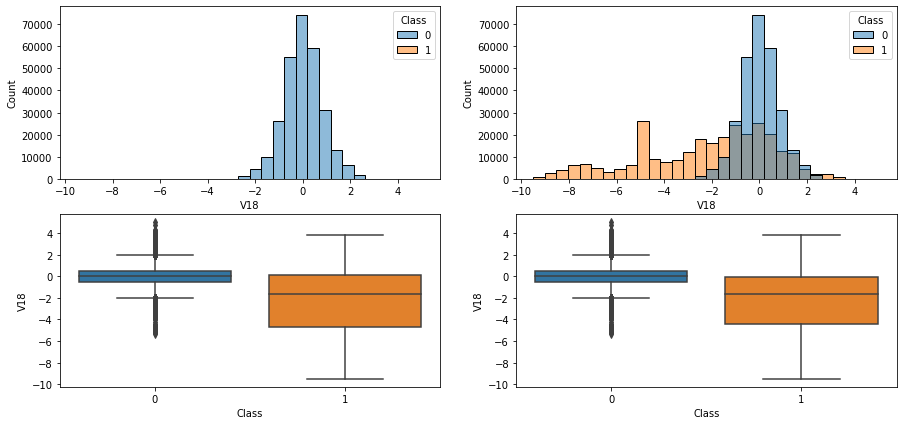

In [68]:
col_name = 'V18'
fig, ax = plt.subplots(2, 2, figsize=(15, 7))

sns.histplot(data=rawData, x=col_name, bins=30, hue='Class', ax=ax[0, 0])
sns.histplot(data=rawData_over, x=col_name, bins=30, hue='Class', ax=ax[0, 1])

sns.boxplot(data=rawData, x='Class', y=col_name, ax=ax[1, 0])
sns.boxplot(data=rawData_over, x='Class', y=col_name, ax=ax[1, 1])

### 언더샘플링
- 랜덤

In [69]:
sample = RandomUnderSampler()
x_under_random, y_under_random = sample.fit_resample(x, y)
np.unique(y_under_random, return_counts=True)

(array([0, 1]), array([492, 492]))

In [70]:
rawData_under = pd.concat([x_under_random, y_under_random], axis=1)

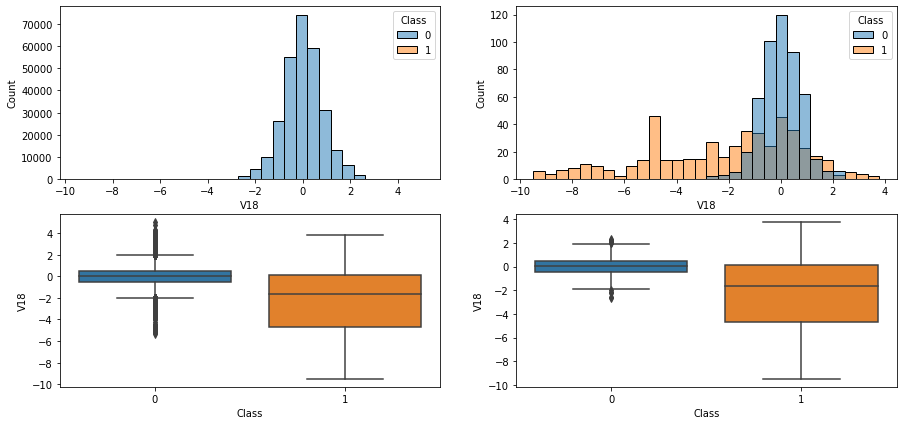

In [71]:
col_name = 'V18'
fig, ax = plt.subplots(2, 2, figsize=(15, 7))

sns.histplot(data=rawData, x=col_name, bins=30, hue='Class', ax=ax[0, 0])
sns.histplot(data=rawData_under, x=col_name, bins=30, hue='Class', ax=ax[0, 1])

sns.boxplot(data=rawData, x='Class', y=col_name, ax=ax[1, 0])
sns.boxplot(data=rawData_under, x='Class', y=col_name, ax=ax[1, 1])

## 모델링 2
- 시간관계상 언더샘플링된 데이터로 실습

In [83]:
x_train, x_val, y_train, y_val = train_test_split(x_under_random, y_under_random, train_size=0.7, shuffle=True)

자료가 줄었으니 파라미터 튜닝(파인-튜닝)도 같이 해봅니다.

In [84]:
folds = StratifiedKFold( n_splits=10, shuffle=True)

In [85]:
model = LogisticRegression()

params = dict(
  penalty = ['elasticnet', 'none'], 
  C = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0],
  class_weight = ['balanced', None],
  solver = ['saga'],
  l1_ratio = [0.0, 0.3, 0.5, 0.8, 1.0]
)

search = GridSearchCV( model, param_grid=params, cv=folds, scoring='roc_auc')
search.fit(x_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=True),
             estimator=LogisticRegression(),
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0,
                               1000.0],
                         'class_weight': ['balanced', None],
                         'l1_ratio': [0.0, 0.3, 0.5, 0.8, 1.0],
                         'penalty': ['elasticnet', 'none'],
                         'solver': ['saga']},
             scoring='roc_auc')

In [86]:
print(search.best_params_)

{'C': 0.001, 'class_weight': 'balanced', 'l1_ratio': 0.3, 'penalty': 'elasticnet', 'solver': 'saga'}


In [87]:
best_model = search.best_estimator_

In [88]:
yhat_train = best_model.predict(x_train)
yhat_val = best_model.predict(x_val)

In [89]:
print(classification_report(y_train, yhat_train))

              precision    recall  f1-score   support

           0       0.96      0.63      0.76       341
           1       0.73      0.97      0.83       347

    accuracy                           0.80       688
   macro avg       0.84      0.80      0.80       688
weighted avg       0.84      0.80      0.80       688



In [90]:
print(classification_report(y_val, yhat_val))

              precision    recall  f1-score   support

           0       0.97      0.64      0.77       151
           1       0.72      0.98      0.83       145

    accuracy                           0.80       296
   macro avg       0.85      0.81      0.80       296
weighted avg       0.85      0.80      0.80       296



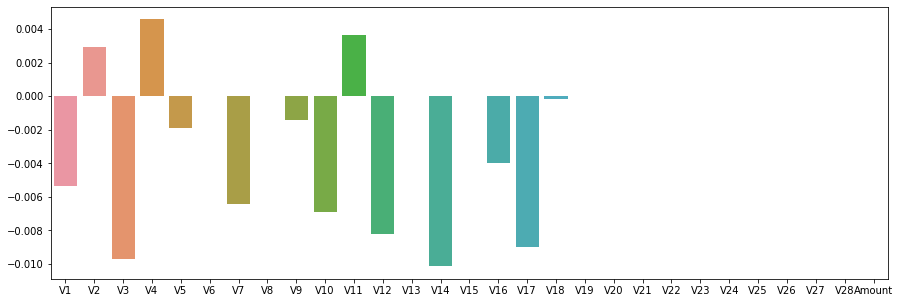

In [91]:
plt.figure(figsize=(15, 5))
sns.barplot(x_val.columns, best_model.coef_[0])

### 앙상블-랜덤포레스트

In [ ]:
params = {
  'criterion': ['gini', 'entropy'],
  'n_estimators': [100, 300, 500, 1000],
  'max_depth': [3, 5, 7, 9, 11, 13, 15],
  'min_samples_split': [8, 16, 20],
  'min_samples_leaf': [8, 12, 18],
}

model = RandomForestClassifier()
search = GridSearchCV( model, param_grid=params, scoring='roc_auc', cv=10)
results = search.fit( x_train, y_train )

In [ ]:
print(results.best_params_ )
print(results.best_score_ )
best_model = results.best_estimator_

{'criterion': 'entropy', 'max_depth': 9, 'min_samples_leaf': 8, 'min_samples_split': 16, 'n_estimators': 300}
0.9804572417202175


In [ ]:
yhat_train = best_model.predict(x_train)
yhat_val = best_model.predict(x_val)

In [ ]:
print(classification_report(y_train, yhat_train))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96       345
           1       1.00      0.92      0.95       343

    accuracy                           0.96       688
   macro avg       0.96      0.96      0.96       688
weighted avg       0.96      0.96      0.96       688



In [ ]:
print(classification_report(y_val, yhat_val))

              precision    recall  f1-score   support

           0       0.88      0.99      0.93       147
           1       0.99      0.87      0.92       149

    accuracy                           0.93       296
   macro avg       0.94      0.93      0.93       296
weighted avg       0.94      0.93      0.93       296



앙상블 계열의 방법들은 모형의 설명력을 위해서 자체적으로 변수의 중요도를 제공

In [ ]:
best_model.feature_importances_

array([0.01087712, 0.02148559, 0.04566226, 0.09174839, 0.00862305,
       0.00773113, 0.04382378, 0.00948139, 0.01258443, 0.12294492,
       0.09452994, 0.11040407, 0.0044899 , 0.17653976, 0.00404593,
       0.05848246, 0.08570428, 0.02042184, 0.01091157, 0.00782954,
       0.01572297, 0.00430623, 0.00511719, 0.00284333, 0.00405425,
       0.0027453 , 0.00335549, 0.00387428, 0.0096596 ])

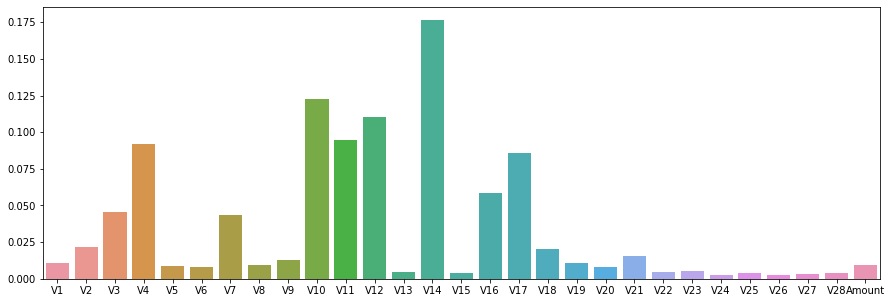

In [ ]:
plt.figure(figsize=(15,5))
sns.barplot(x_val.columns, best_model.feature_importances_)

### XGBoost

In [ ]:
params = {
  'num_boost_rounds': [100, 300, 500, 1000],
  'max_depth': [3, 5, 7, 9, 11, 13, 15],
  'objective': ['binary:hinge']
}

model = xgb.XGBClassifier()
search = GridSearchCV( model, param_grid=params, scoring='roc_auc', cv=5)
results = search.fit( x_train, y_train )

In [ ]:
print(results.best_params_)
print(results.best_score_)
best_model = results.best_estimator_

{'max_depth': 5, 'num_boost_rounds': 100, 'objective': 'binary:hinge'}
0.9186274509803922


In [ ]:
yhat_train = best_model.predict(x_train)
yhat_val = best_model.predict(x_val)

In [ ]:
print(classification_report(y_train, yhat_train))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       345
           1       1.00      1.00      1.00       343

    accuracy                           1.00       688
   macro avg       1.00      1.00      1.00       688
weighted avg       1.00      1.00      1.00       688



In [ ]:
print(classification_report(y_val, yhat_val))

              precision    recall  f1-score   support

           0       0.90      0.96      0.93       147
           1       0.96      0.89      0.92       149

    accuracy                           0.93       296
   macro avg       0.93      0.93      0.93       296
weighted avg       0.93      0.93      0.93       296



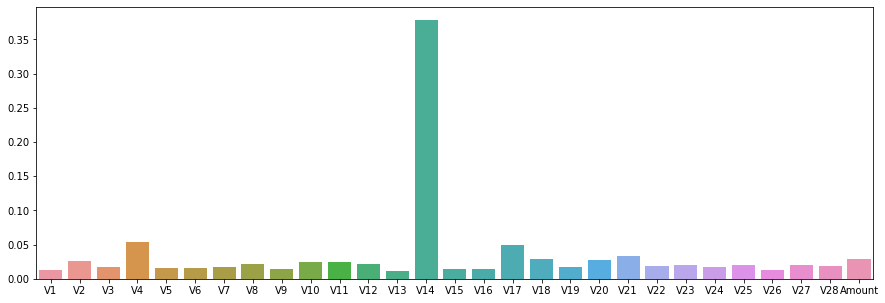

In [ ]:
plt.figure(figsize=(15,5))
sns.barplot(x_val.columns, best_model.feature_importances_)

### CatBoost

In [ ]:
model = cb.CatBoostClassifier().fit(x_train, y_train)

Learning rate set to 0.008782
0:	learn: 0.6800594	total: 69.4ms	remaining: 1m 9s
1:	learn: 0.6686621	total: 77.7ms	remaining: 38.8s
2:	learn: 0.6569593	total: 87.2ms	remaining: 29s
3:	learn: 0.6464076	total: 95ms	remaining: 23.7s
4:	learn: 0.6360135	total: 103ms	remaining: 20.5s
5:	learn: 0.6258390	total: 111ms	remaining: 18.3s
6:	learn: 0.6155317	total: 118ms	remaining: 16.8s
7:	learn: 0.6044578	total: 126ms	remaining: 15.7s
8:	learn: 0.5939937	total: 134ms	remaining: 14.8s
9:	learn: 0.5856207	total: 142ms	remaining: 14.1s
10:	learn: 0.5749084	total: 150ms	remaining: 13.5s
11:	learn: 0.5640764	total: 158ms	remaining: 13s
12:	learn: 0.5550797	total: 166ms	remaining: 12.6s
13:	learn: 0.5458107	total: 174ms	remaining: 12.2s
14:	learn: 0.5361638	total: 194ms	remaining: 12.7s
15:	learn: 0.5274121	total: 205ms	remaining: 12.6s
16:	learn: 0.5185621	total: 212ms	remaining: 12.3s
17:	learn: 0.5092703	total: 220ms	remaining: 12s
18:	learn: 0.5014599	total: 228ms	remaining: 11.8s
19:	learn: 0.49

In [ ]:
yhat_train = model.predict(x_train)
yhat_val = model.predict(x_val)

In [ ]:
print(classification_report(y_train, yhat_train))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       345
           1       1.00      1.00      1.00       343

    accuracy                           1.00       688
   macro avg       1.00      1.00      1.00       688
weighted avg       1.00      1.00      1.00       688



In [ ]:
print(classification_report(y_val, yhat_val))

              precision    recall  f1-score   support

           0       0.89      0.98      0.93       147
           1       0.98      0.88      0.93       149

    accuracy                           0.93       296
   macro avg       0.93      0.93      0.93       296
weighted avg       0.93      0.93      0.93       296



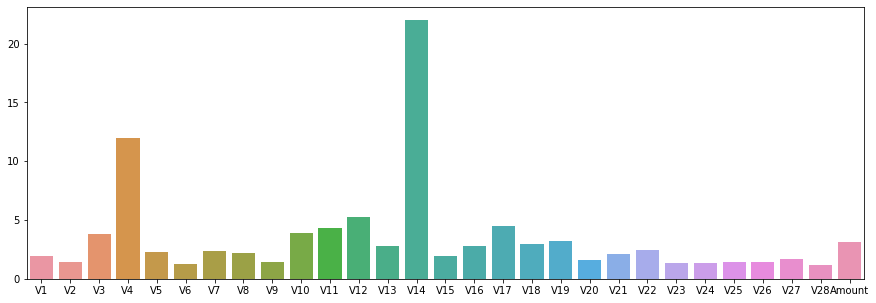

In [ ]:
plt.figure(figsize=(15,5))
sns.barplot(x_val.columns, model.feature_importances_)

### Stacking

In [ ]:
estimators = [
  ('RandomForest', RandomForestClassifier(criterion='entropy', max_depth=9, n_estimators=1000) ),
  ('XGBoost', xgb.XGBClassifier(n_estimators=1000) ), 
  ('LGBM', lgb.LGBMClassifier(n_estimators=1000) ),
  ('CB', cb.CatBoostClassifier() )
]

model = StackingClassifier( estimators=estimators, final_estimator=LogisticRegression() )
model.fit(x_train, y_train)

In [ ]:
yhat_train = model.predict(x_train)
yhat_val = model.predict(x_val)

In [ ]:
print(classification_report(y_train, yhat_train))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       338
           1       1.00      1.00      1.00       350

    accuracy                           1.00       688
   macro avg       1.00      1.00      1.00       688
weighted avg       1.00      1.00      1.00       688



In [ ]:
print( classification_report(y_val, yhat_val))

              precision    recall  f1-score   support

           0       0.94      0.93      0.93       154
           1       0.92      0.94      0.93       142

    accuracy                           0.93       296
   macro avg       0.93      0.93      0.93       296
weighted avg       0.93      0.93      0.93       296



# 비지도 학습

## 군집화(Clustering)
- 비지도 학습(Unsupervised Learning) 으로 잘 알려져 있습니다. 
- Y가 없는 자료
  - 주어진 X들만 가지고, 자료를 특성별로 묶어주는 방법(군집)
  - 실제로는 정확도가 높은 방법은 아니라서, 단독으로 사용하는 경우는 드뭅니다.

- Semi-Supervied(준지도)
  - 응용된 형태 
  - 지도학습 기반의 알고리즘들이 정확도가 높기 때문에 사용할 수 있다면 지도학습을 사용하면 됩니다.
  - 그런데, 지도학습을 사용하기가 어려운 경우가 있습니다. 
    - 자료를 수집하는 것 자체도 쉬운일은 아닙니다.
    - 수집이 된다고 하더라도, 레이블링은 사람이 해야 합니다.
    - 군집화를 통해서 레이블링을 하고 지도학습에 사용
    - 레이블링된 자료가 충분히 많다면, 크게 효과가 없다고 알려져 있습니다.

- 군집화 방법은
  - 거리, 분포, 밀도를 기반으로 해서 자료를 분류

In [164]:
faithful = pd.read_csv('/content/drive/MyDrive/멀티캠퍼스/data/faithful.csv')
faithful.head()

,eruptions,waiting
0,3.600,79
1,1.800,54
2,3.333,74
3,2.283,62
4,4.533,85


- 미국의 옐로스톤 국립공원의 간헐천의 분출지속시간과 분출사이의 간격(시간차)을 나타낸 자료

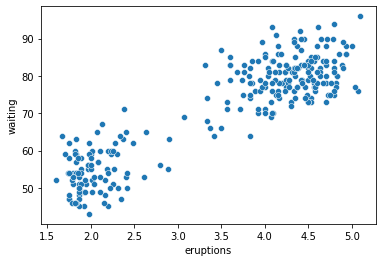

In [165]:
sns.scatterplot(faithful.eruptions, faithful.waiting)
plt.show()

### K-Means Clustering
- 거리를 기반으로 하는 알고리즘
  - 자료와 자료 사이의 거리가 가까우면 같은 특징을 가질 것으로 가정
  - 군집의 갯수는 미리 알고 있어야 합니다.
- 알고리즘의 동작 과정
  1. 초기 중심점을 아무렇게나 찍습니다.(초기 중심점에 따라서 결과는 달라질 수 있습니다. )
  2. 모든 자료에서 중심점과 자료간의 거리를 계산, 중심점을 기준으로 더 가까운 자료를 하나의 클래스로 할당(군집)
  3. 클래스의 평균점을 구합니다.(해당 클래스의 새로운 중심점)
  4. 새로운 중심점을 기준으로 2번의 과정으로 돌아가 반복
  5. 지정된 횟수 또는 중심점이 더 이상 움직이지 않을때까지 반복

1. 초기 중심점을 아무렇게나 찍습니다.
  - 실제로는 랜덤하게 정하는데, 여러변 반복하면서 확인해봐야 합니다.

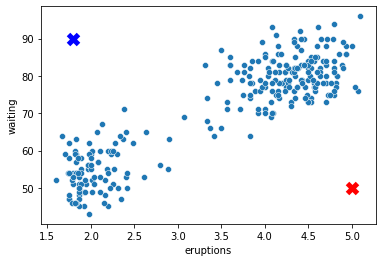

In [166]:
centroid = np.array([
                    [1.8, 90],
                    [5.0, 50]
])

sns.scatterplot(faithful.eruptions, faithful.waiting)
plt.plot(centroid[0, 0], centroid[0, 1], 'bx', markersize=10, markeredgewidth=5)
plt.plot(centroid[1, 0], centroid[1, 1], 'rx', markersize=10, markeredgewidth=5)

2. 모든 자료에서 중심점과 거리를 계산, 거리가 가까운 쪽으로 클래스를 할당

In [167]:
faith = faithful.to_numpy()
faith[:5]

array([[ 3.6  , 79.   ],
       [ 1.8  , 54.   ],
       [ 3.333, 74.   ],
       [ 2.283, 62.   ],
       [ 4.533, 85.   ]])

In [168]:
k = 2

cls = np.zeros((faith.shape[0], k))
cls[:5]

array([[0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.]])

In [169]:
# 중심점과의 거리 계산
for n in range(faith.shape[0]):
  x = faith[n]

  dist1 = np.linalg.norm(x-centroid[0]) # 파란점과의 거리
  dist2 = np.linalg.norm(x-centroid[1]) # 빨간점과의 거리

  if dist1 < dist2:
    cls[n, 0] = 1
  else:
    cls[n, 1] = 1

In [170]:
cls[:5]

array([[1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.]])

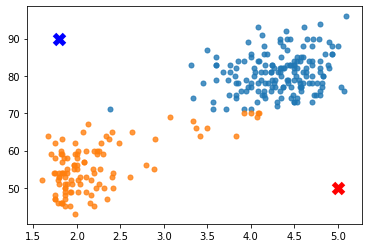

In [171]:
blue = faith[np.where(cls[:, 0] == 1)]
red = faith[np.where(cls[:, 1] == 1)]

plt.plot(blue[:, 0], blue[:, 1], 'o', markersize=5, alpha=0.8)
plt.plot(red[:, 0], red[:, 1], 'o', markersize=5, alpha=0.8)
plt.plot(centroid[0, 0], centroid[0, 1], 'bx', markersize=10, markeredgewidth=5)
plt.plot(centroid[1, 0], centroid[1, 1], 'rx', markersize=10, markeredgewidth=5)

3. 각 클래스의 평균을 구하고 중심점을 업데이트

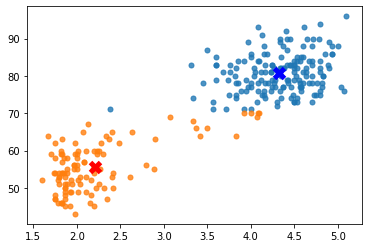

In [172]:
centroid[0] = blue.mean(axis=0)
centroid[1] = red.mean(axis=0)

plt.plot(blue[:, 0], blue[:, 1], 'o', markersize=5, alpha=0.8)
plt.plot(red[:, 0], red[: ,1], 'o', markersize=5, alpha=0.8)
plt.plot(centroid[0, 0], centroid[0, 1], 'bx', markersize=10, markeredgewidth=5)
plt.plot(centroid[1, 0], centroid[1, 1], 'rx', markersize=10, markeredgewidth=5)

In [145]:
from sklearn.cluster import KMeans

In [146]:
kmeans = KMeans(n_clusters=2).fit(faith)

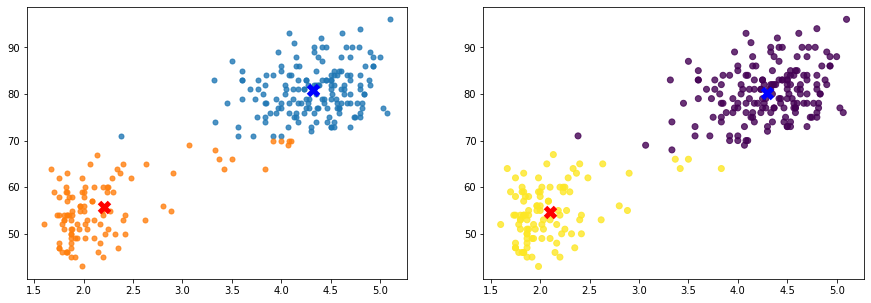

In [173]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(blue[:, 0], blue[:, 1], 'o', markersize=5, alpha=0.8)
plt.plot(red[:, 0], red[: ,1], 'o', markersize=5, alpha=0.8)
plt.plot(centroid[0, 0], centroid[0, 1], 'bx', markersize=10, markeredgewidth=5)
plt.plot(centroid[1, 0], centroid[1, 1], 'rx', markersize=10, markeredgewidth=5)

plt.subplot(1, 2, 2)
plt.scatter(faithful.eruptions, faithful.waiting, c=kmeans.labels_, alpha=0.8)
plt.plot(kmeans.cluster_centers_[0, 0], kmeans.cluster_centers_[0, 1], 'bx', markersize=10, markeredgewidth=5)
plt.plot(kmeans.cluster_centers_[1, 0], kmeans.cluster_centers_[1, 1], 'rx', markersize=10, markeredgewidth=5)

plt.show()

#### Elbow method
- K-Means와 같은 경우 군집간의 거리의 합을 나타내는 `Inertia`를 미리 계산
- 급격히 변하는 구간이 있는데 이 구간을 엘보우 구간이라고 해서 군집의 개수로 사용

In [187]:
dist = []

for k in range(1, 11):
  model = KMeans(n_clusters=k).fit(faithful)
  dist.append(model.inertia_)

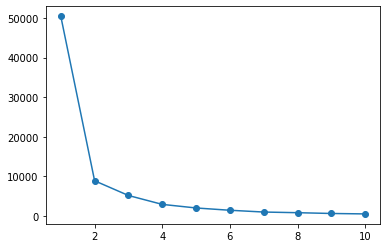

In [188]:
plt.plot(range(1, 11), dist, 'o-')

##### KElbowVisualizer
- elbow method와 동일한 방법
- 모델 훈련과 그래프를 그리는 동시에 훈련시간까지 표시

In [190]:
!pip install yellowbrick

In [191]:
from yellowbrick.cluster import KElbowVisualizer

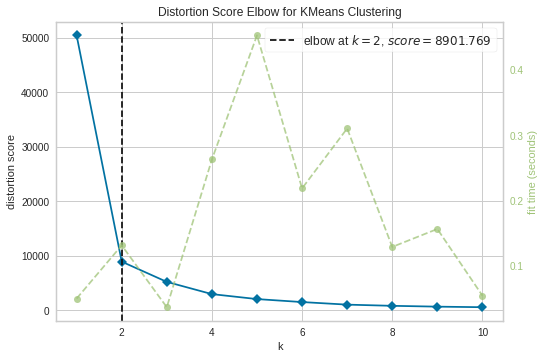

In [192]:
km = KMeans()
visualizer = KElbowVisualizer(km, k=(1, 11))
visualizer.fit(faithful)
visualizer.poof()

##### Kneed

In [193]:
!pip install kneed

In [194]:
from kneed import KneeLocator

In [196]:
dist = []
for k in range(1, 11):
  model = KMeans(n_clusters=k).fit(faithful)
  dist.append(model.inertia_)

In [198]:
result = KneeLocator(x=range(1, 11), y=dist, curve='convex', direction='decreasing')

In [200]:
print(f'best k is: {result.elbow}')

best k is: 2


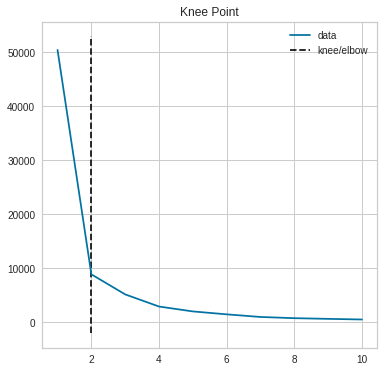

In [201]:
result.plot_knee()

#### Silhouette method
- K를 찾는 전혀 다른 방법
- 각 클러스터(군집)내의 거리 뿐만 아니라, 군집과 군집간의 거리도 함께 고려
![](https://blog.kakaocdn.net/dn/zSiVB/btqxQpIo8Ov/vyDaAmHJMtJRBlZg3DZ041/img.png)

- 각 군집들간의 거리가 멀고, 군집내의 거리는 작을수록 군집화의 성능이 좋다라고 얘기할 수 있습니다.
  - 실루엣 값은 -1에서 1사이의 값을 갖습니다.
  - 0이면 군집간의 변별력이 떨어진다는 의미
  - -1에 가까울수록 군집화의 결과가 좋지 않다는 의미

In [202]:
from sklearn.metrics import silhouette_score

In [206]:
scores = []

for k in range(2, 11):
  model = KMeans(n_clusters=k).fit(faithful)
  labels = model.predict(faithful)
  sc = silhouette_score(faithful.to_numpy(), labels, metric='euclidean', sample_size=None)
  scores.append(sc)

In [207]:
scores

[0.724054851995858,
 0.5803618842550007,
 0.553916636789305,
 0.5481460043306785,
 0.5392195994985671,
 0.5478545412774276,
 0.5378836868219594,
 0.5245599886173694,
 0.5308654798691597]

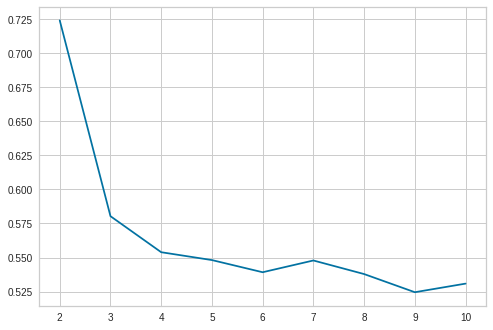

In [209]:
plt.plot(range(2, 11), scores)
plt.show()

In [210]:
from yellowbrick.cluster import SilhouetteVisualizer

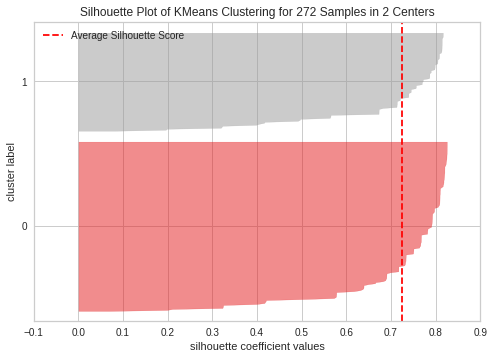

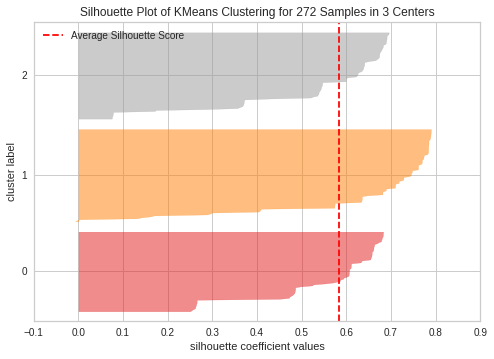

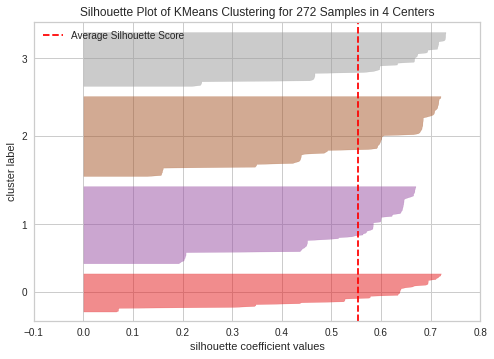

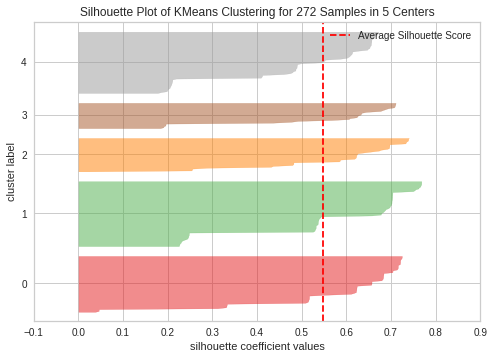

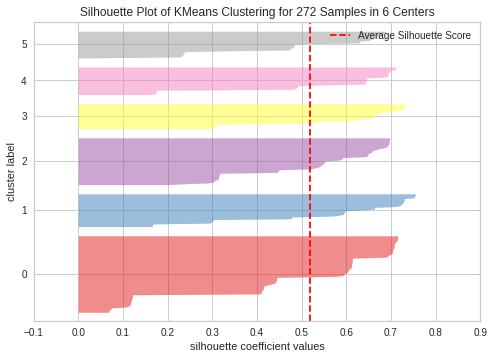

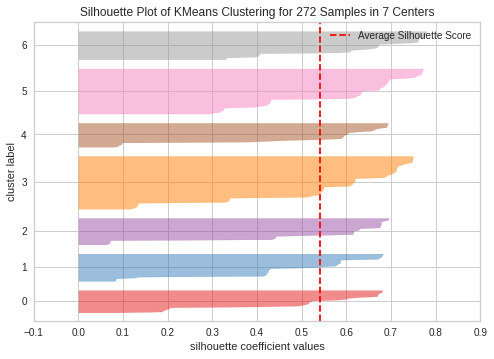

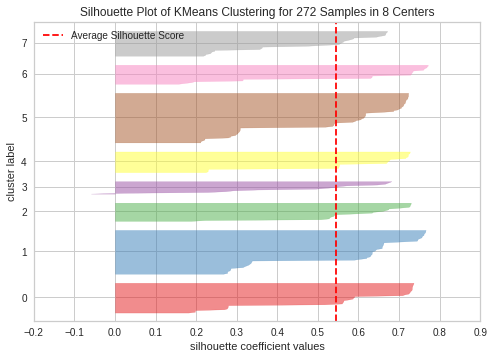

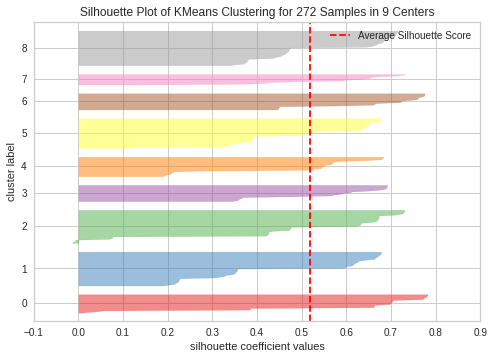

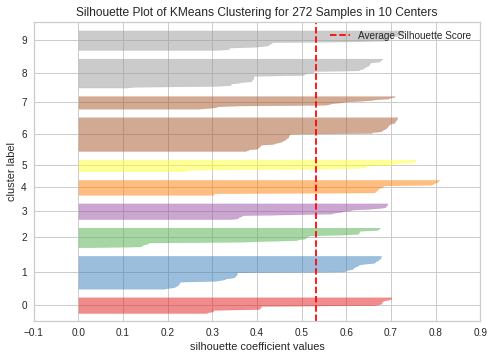

In [213]:
for k in range(2, 11):
  model = KMeans(n_clusters=k)
  visualizer = SilhouetteVisualizer(model)
  visualizer.fit(faithful)
  visualizer.poof()

plt.show()

### GMM(Gaussian Mixture Model)
- 자료가 K개의 정규분포로부터 생성되었다고 가정
 - 전체 자료가 하나으 분포로 이루어져 있지 않고 하위 분포들이 존재할 것이라고 가정

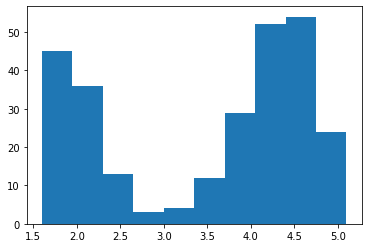

In [174]:
plt.hist(faithful.eruptions)
plt.show()

In [214]:
from sklearn.mixture import GaussianMixture

In [176]:
gm = GaussianMixture(n_components=2).fit(faithful)

In [178]:
gm_labels = gm.predict(faithful)
gm_labels

array([1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0,
       1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1,
       1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1,
       1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1,
       1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1,
       1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1,
       0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0,
       1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1,
       0, 0, 1, 1, 0, 1, 0, 1])

K-Means와 비교

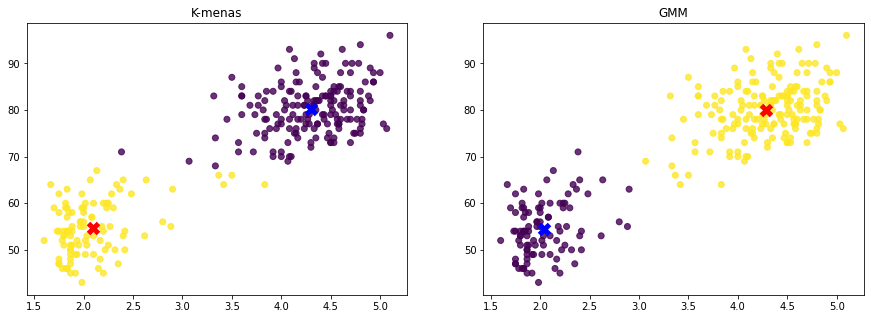

In [180]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.scatter(faithful.eruptions, faithful.waiting, c=kmeans.labels_, alpha=0.8)
plt.plot(kmeans.cluster_centers_[0, 0], kmeans.cluster_centers_[0, 1], 'bx', markersize=10, markeredgewidth=5)
plt.plot(kmeans.cluster_centers_[1, 0], kmeans.cluster_centers_[1, 1], 'rx', markersize=10, markeredgewidth=5)
plt.title('K-menas')

plt.subplot(1, 2, 2)
plt.scatter(faithful.eruptions, faithful.waiting, c=gm_labels, alpha=0.8)
plt.plot(gm.means_[0, 0], gm.means_[0, 1], 'bx', markersize=10, markeredgewidth=5)
plt.plot(gm.means_[1, 0], gm.means_[1, 1], 'rx', markersize=10, markeredgewidth=5)
plt.title('GMM')
plt.show()

### DBSCAN
- Density-Based Spatial Clustering of Application with Noise
- 밀도를 기반으로 하는 클러스터링
- K를 몰라도 됩니다.
  - 군집의 개수를 미리 알고 있지 않아도 됩니다.
  - 높은 밀도의 그룹들을 군집화
  - 반경 epsilon내의 n개 이상의 점이 있으면, 하나의 군집으로 인식
  - 이때, 군집에 포함되지 못하는 자료들은 outlier가 됩니다. 
    - outlier detection 용도로 사용되는 경우도 있습니다. 

![](https://user-images.githubusercontent.com/53929665/103149384-39869380-47ac-11eb-8b8c-649036630985.png)

In [215]:
from sklearn.cluster import DBSCAN

In [216]:
dbscan = DBSCAN(eps=2, min_samples=2).fit(faithful)
db_labels = dbscan.fit_predict(faithful)

In [217]:
db_labels

array([ 0,  1,  0,  0,  0,  1,  0,  0,  1,  0,  1,  0,  0,  1,  0,  1,  0,
        0,  1,  0,  1,  1,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,
        0,  1,  1,  0,  1,  0,  0,  1,  0,  1,  0,  0,  0,  1,  0,  1,  0,
        0,  1,  0,  1,  0,  0,  0,  0,  0,  1,  0,  1,  0,  1,  0,  0,  0,
        0,  0,  0,  1,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  1,  0,  1,  0,  1,  0,  0,  0,  0,  0,  1,  0,  0,  0,
        1,  0,  0,  1,  0,  1,  0,  0,  0,  1,  0,  0,  1,  0,  1,  0,  1,
        0,  1,  0,  0,  1,  0,  0,  1,  0,  1,  0,  1,  0,  1,  0,  1,  0,
        1,  0,  1,  0,  0,  1,  0,  0,  0,  1,  0,  1, -1,  1,  0,  0,  0,
        0,  0,  0,  0,  0,  1,  0,  1,  0,  1,  0,  0,  0,  0,  0,  1,  0,
        1,  1,  0,  0,  0,  0,  0,  1,  0,  0,  1,  0,  0,  0,  1,  0,  0,
        1,  0,  1,  0,  1,  0,  0,  0,  0,  0,  0,  1,  0,  1,  0,  0,  1,
        0,  1,  0,  0,  1,  0,  0,  0,  1,  0,  0,  0,  1,  0,  1,  0,  1,
        0,  1,  0,  0,  0

In [219]:
sns.reset_orig()

Text(0.5, 1.0, 'DBSCAN')

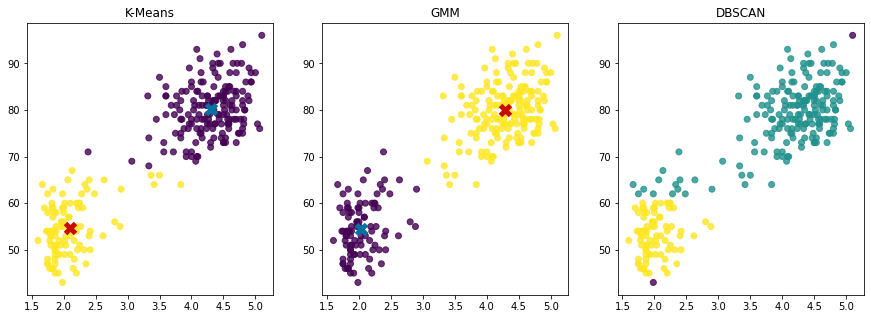

In [220]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.scatter( faithful.eruptions, faithful.waiting, c=kmeans.labels_, alpha=0.8)
plt.plot( kmeans.cluster_centers_[0, 0], kmeans.cluster_centers_[0, 1], 'bx', markersize=10, markeredgewidth=5)
plt.plot( kmeans.cluster_centers_[1, 0], kmeans.cluster_centers_[1, 1], 'rx', markersize=10, markeredgewidth=5)
plt.title('K-Means')

plt.subplot(1, 3, 2)
plt.scatter( faithful.eruptions, faithful.waiting, c=gm_labels, alpha=0.8)
plt.plot( gm.means_[0, 0], gm.means_[0, 1], 'bx', markersize=10, markeredgewidth=5)
plt.plot( gm.means_[1, 0], gm.means_[1, 1], 'rx', markersize=10, markeredgewidth=5)
plt.title('GMM')

plt.subplot(1, 3, 3)
plt.scatter( faithful.eruptions, faithful.waiting, c=db_labels, alpha=0.8)
plt.title('DBSCAN')

### Agglomerative
- 계층적 군집화
  - K-Means의 단점을 보완한 방법
    - 노이즈(이상치)에 민감함
    - 초기에 주어지는 중심점의 위치에 따라서 결과가 달라진다.
    - k를 미리 알고 있어야 한다.
  - Agglomerative
    - K를 정하지 않아도 사용할 수 있다.
    - 초기 중심점을 사용하지 않기 때문에, 항상 동일한 결과
    - 시각화가 가능(어떻게 군집이 생성됐는지도 확인)
  - 가장 큰 단점은
    - 느려요
    - 자료가 아주 많은 경우에는 사용이 어렵다(계산 시간이 오래 걸림)
    - 샘플만 추출해서 전체적인 군집의 분포를 확인하는 용도로 사용이 가능

In [221]:
from sklearn.cluster import AgglomerativeClustering

- 파라미터
1. linkage: 가장 비슷한 클러스터를 측정하는 방법
  - 'ward', 'complete', 'average', 'single'
  - ward(기본값): 군집내의 분산을 가장 작게 하는 군집을 하나로 합치는 방법
  - complete: 군집들간의 거리가 가장 짧은 두 군집을 하나로 합치는 방법
  - average: 군집들 사이의 평균 거리가 가장 짧은 두 군집을 하나로 합치는 방법

- linkage가 ward이면 affinity는 euclidean만 사용이 가능

In [222]:
aggModel = AgglomerativeClustering(linkage='ward', affinity='euclidean').fit(faithful)

왜 계층군집이라고 불리우는가?
- 초기에는 각각 포인트가 하나의 군집이 됩니다.
- 가장 가까운 두 군집들이 하나로 합쳐지면서 군집화가 진행

In [223]:
from scipy.cluster.hierarchy import dendrogram, linkage, ward

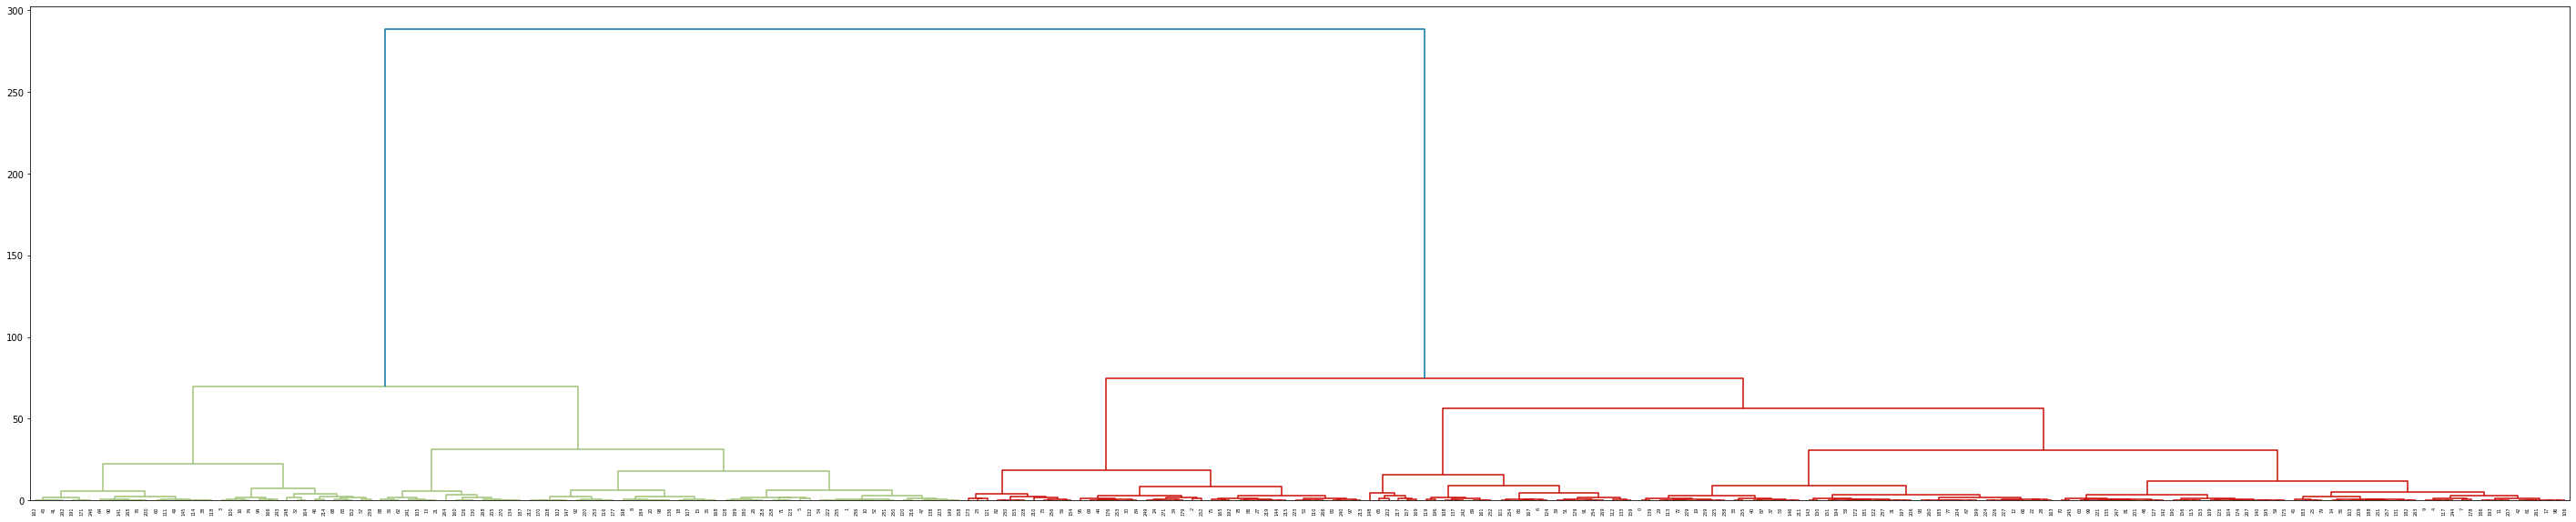

In [224]:
plt.figure(figsize=(50, 10))
faithful_linkage = ward(faithful)
dendrogram(faithful_linkage)
plt.show()

In [225]:
aggModel = AgglomerativeClustering( n_clusters=2, linkage='ward', affinity='euclidean').fit(faithful)
agg_labels = aggModel.fit_predict(faithful)

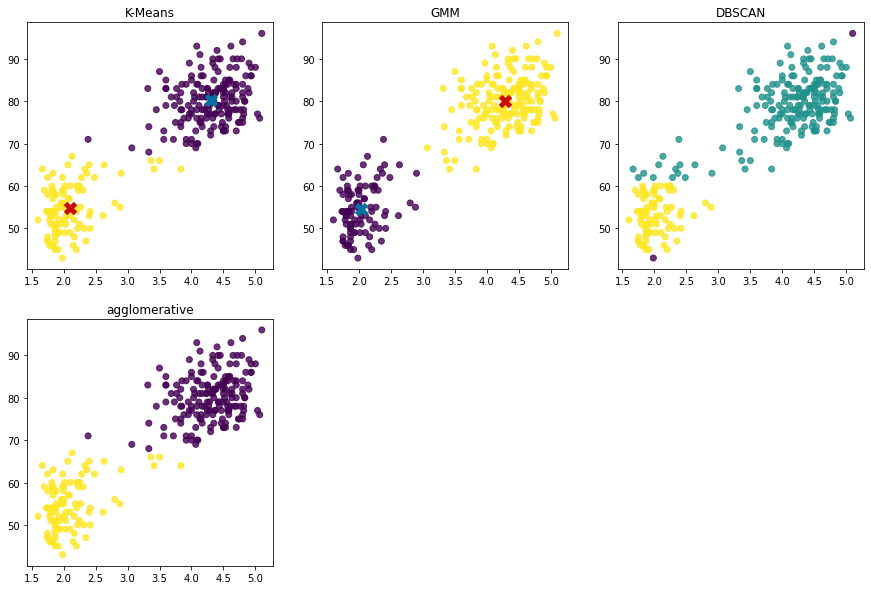

In [226]:
plt.figure( figsize=(15, 10))

plt.subplot(2, 3, 1)
plt.scatter( faithful.eruptions, faithful.waiting, c=kmeans.labels_, alpha=0.8)
plt.plot( kmeans.cluster_centers_[0, 0], kmeans.cluster_centers_[0, 1], 'bx', markersize=10, markeredgewidth=5)
plt.plot( kmeans.cluster_centers_[1, 0], kmeans.cluster_centers_[1, 1], 'rx', markersize=10, markeredgewidth=5)
plt.title('K-Means')

plt.subplot(2, 3, 2)
plt.scatter( faithful.eruptions, faithful.waiting, c=gm_labels, alpha=0.8)
plt.plot( gm.means_[0, 0], gm.means_[0, 1], 'bx', markersize=10, markeredgewidth=5)
plt.plot( gm.means_[1, 0], gm.means_[1, 1], 'rx', markersize=10, markeredgewidth=5)
plt.title('GMM')

plt.subplot(2, 3, 3)
plt.scatter( faithful.eruptions, faithful.waiting, c=db_labels, alpha=0.8 )
plt.title('DBSCAN')

plt.subplot(2, 3, 4)
plt.scatter( faithful.eruptions, faithful.waiting, c=agg_labels, alpha=0.8 )
plt.title('agglomerative')

plt.show()

### HDBSCAN
- 계층적 DBSCAN
- 기존의 DBSCAN + 계층적 군집화
- 기존의 DBSCAN과의 차이점
  - epsiloin을 설정할 필요가 없다(파라미터 튜닝에 들어가는 비용이 줄어들 수 있다. )

- 파라미터
  - min_cluster_size(default=5): 클러스터의 최소 크기
  - cluster_selection_epsilon(default=0.0)
    - 클러스터의 기준이 되는 거리, 이 거리보다 아래의 거리는 같은 클러스터로 합쳐지게 됩니다.
    - DBSCAN + HDBSCAN
  - min_samples(default=None): 반경내에 있어야할 데이터의 최소 크기
    - 값이 높을수록 outlier가 많아지게 됩니다.

In [228]:
!pip install hdbscan

In [230]:
from hdbscan import HDBSCAN

In [232]:
hdbModel = HDBSCAN(min_cluster_size=10).fit(faithful)
hdb_labels = hdbModel.fit_predict(faithful)

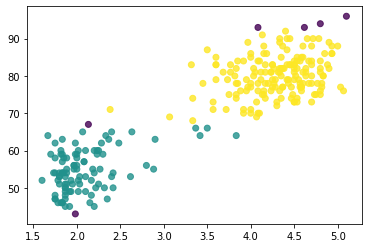

In [233]:
plt.scatter(faithful.eruptions, faithful.waiting, c=hdb_labels, alpha=0.8)
plt.show()

원하는 밀도만큼 DBSCAN을 수행하고, 나머지에 대해서 HDBSCAN을 수행

In [234]:
hdbModel = HDBSCAN(min_cluster_size=30, cluster_selection_epsilon=0.5).fit(faithful)
hdb_labels = hdbModel.fit_predict(faithful)

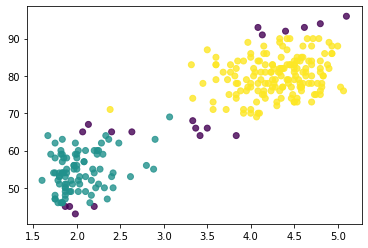

In [236]:
plt.scatter(faithful.eruptions, faithful.waiting, c=hdb_labels, alpha=0.8)
plt.show()

왜 계층적 구조인가?

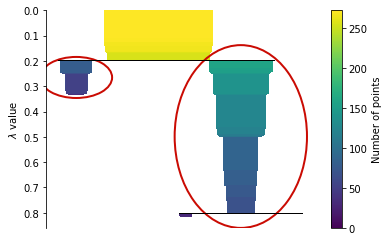

In [237]:
hdbModel.condensed_tree_.plot(select_clusters=True)
plt.show()

## 클러스터링 비교

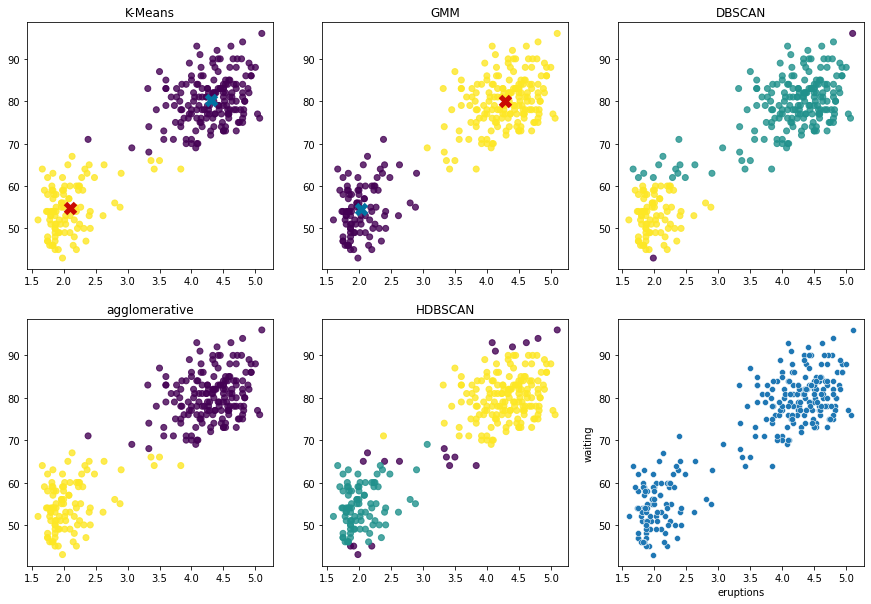

In [238]:
plt.figure( figsize=(15, 10))

plt.subplot(2, 3, 1)
plt.scatter( faithful.eruptions, faithful.waiting, c=kmeans.labels_, alpha=0.8)
plt.plot( kmeans.cluster_centers_[0, 0], kmeans.cluster_centers_[0, 1], 'bx', markersize=10, markeredgewidth=5)
plt.plot( kmeans.cluster_centers_[1, 0], kmeans.cluster_centers_[1, 1], 'rx', markersize=10, markeredgewidth=5)
plt.title('K-Means')

plt.subplot(2, 3, 2)
plt.scatter( faithful.eruptions, faithful.waiting, c=gm_labels, alpha=0.8)
plt.plot( gm.means_[0, 0], gm.means_[0, 1], 'bx', markersize=10, markeredgewidth=5)
plt.plot( gm.means_[1, 0], gm.means_[1, 1], 'rx', markersize=10, markeredgewidth=5)
plt.title('GMM')

plt.subplot(2, 3, 3)
plt.scatter( faithful.eruptions, faithful.waiting, c=db_labels, alpha=0.8 )
plt.title('DBSCAN')

plt.subplot(2, 3, 4)
plt.scatter( faithful.eruptions, faithful.waiting, c=agg_labels, alpha=0.8 )
plt.title('agglomerative')

plt.subplot(2, 3, 5)
plt.scatter( faithful.eruptions, faithful.waiting, c=hdb_labels, alpha=0.8 )
plt.title('HDBSCAN')

plt.subplot(2, 3, 6)
sns.scatterplot( faithful.eruptions, faithful.waiting )

plt.show()

## 실습

In [239]:
iris = datasets.load_iris()
print( iris['feature_names'] )
print( iris['target_names'] )

['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
['setosa' 'versicolor' 'virginica']


In [240]:
x = iris.data
y = iris.target

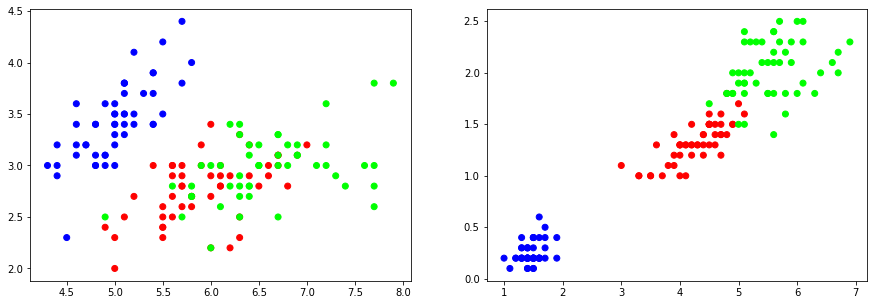

In [241]:
plt.figure( figsize=(15,5) )

plt.subplot(1, 2, 1)
plt.scatter( x[:, 0], x[:, 1], c=y, cmap='brg')

plt.subplot(1, 2, 2)
plt.scatter( x[:, 2], x[:, 3], c=y, cmap='brg')

우리는 붓꽃의 종류가 얼마나 있는지 모른다고 가정

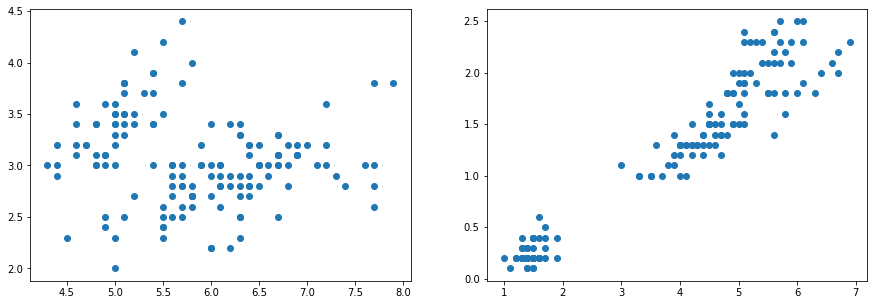

In [247]:
plt.figure( figsize=(15,5) )

plt.subplot(1, 2, 1)
plt.scatter( x[:, 0], x[:, 1] )

plt.subplot(1, 2, 2)
plt.scatter( x[:, 2], x[:, 3] )
plt.show()

### 적당한 K는 얼마?

In [242]:
dist = []
for k in range(1, 11):
  model = KMeans(n_clusters=k).fit(x)
  dist.append(model.inertia_)

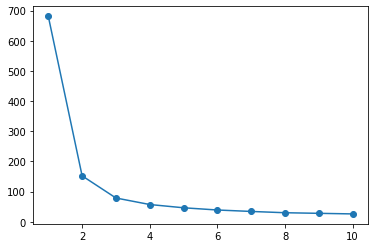

In [243]:
plt.plot(range(1, 11), dist, 'o-')
plt.show()

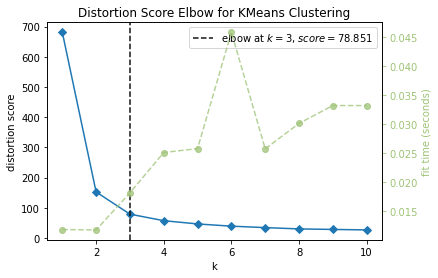

In [245]:
km = KMeans()
visualizer = KElbowVisualizer(km, k=(1, 11))
visualizer.fit(x)
visualizer.poof()
plt.show()

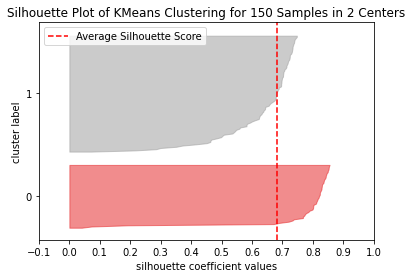

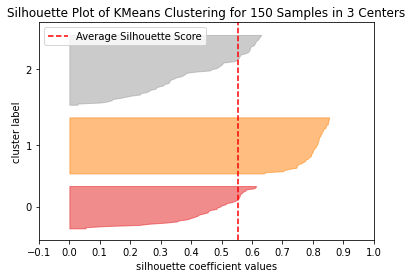

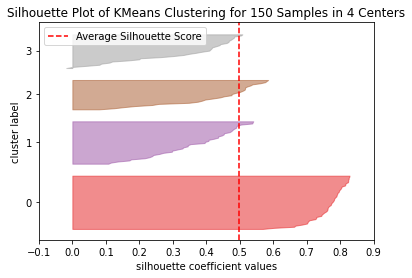

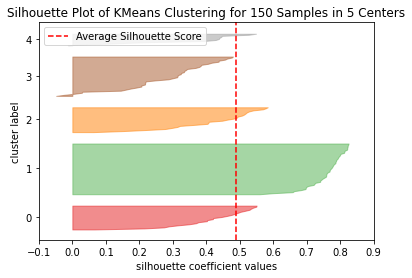

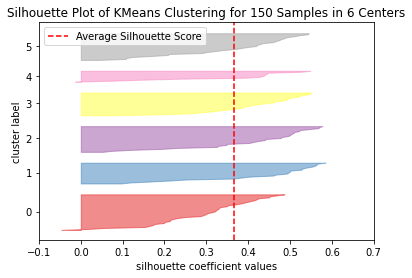

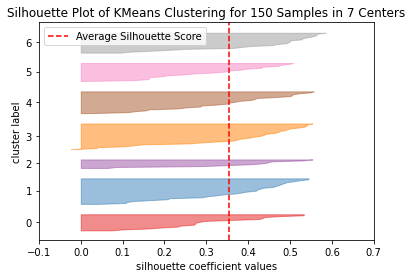

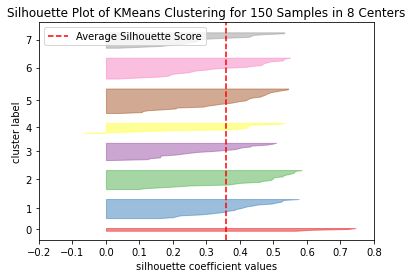

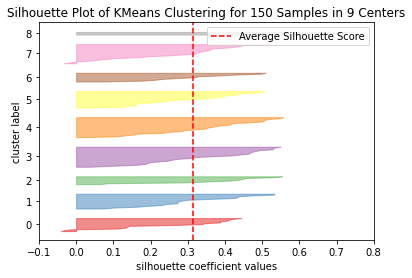

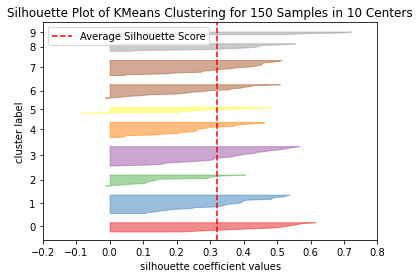

In [246]:
for k in range(2, 11):
  model = KMeans(n_clusters=k)
  visualizer = SilhouetteVisualizer(model)
  visualizer.fit(x)
  visualizer.poof()

## KMeans

In [248]:
kmeans = KMeans(n_clusters=3).fit(x)

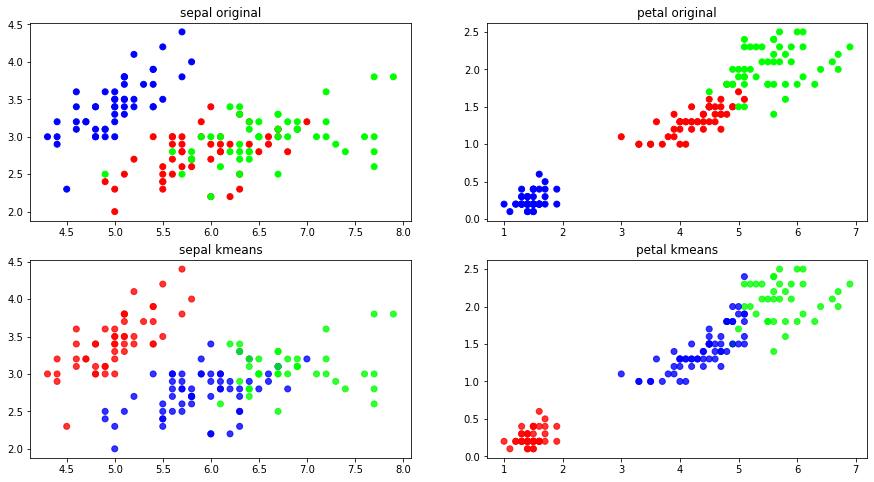

In [250]:
plt.figure( figsize=(15,8) )

plt.subplot(2, 2, 1)
plt.scatter( x[:, 0], x[:, 1], c=y, cmap='brg')
plt.title('sepal original')

plt.subplot(2, 2, 2)
plt.scatter( x[:, 2], x[:, 3], c=y, cmap='brg')
plt.title('petal original')

plt.subplot(2, 2, 3)
plt.scatter( x[:, 0], x[:, 1], c=kmeans.labels_, cmap='brg', alpha=0.8)
plt.title('sepal kmeans')

plt.subplot(2, 2, 4)
plt.scatter( x[:, 2], x[:, 3], c=kmeans.labels_, cmap='brg', alpha=0.8)
plt.title('petal kmeans')

plt.show()

### GMM

In [251]:
gm = GaussianMixture( n_components=3 ).fit(x)
gm_labels = gm.predict(x)

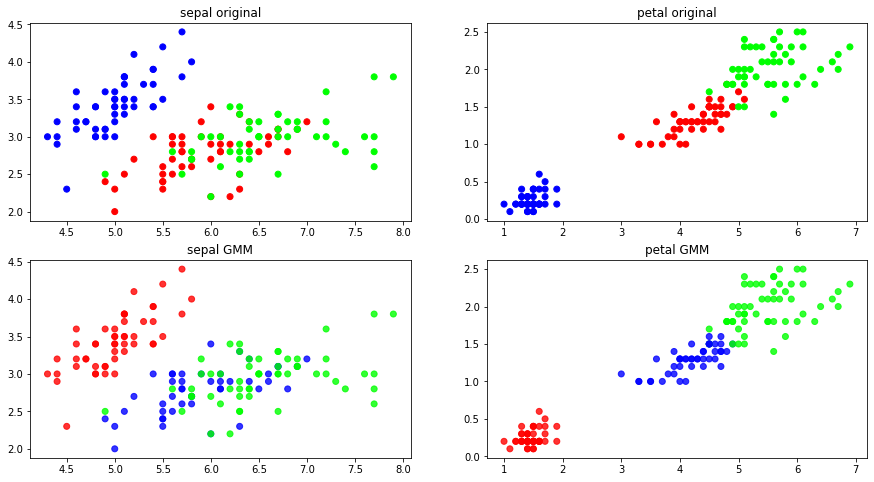

In [252]:
plt.figure( figsize=(15,8) )

plt.subplot(2, 2, 1)
plt.scatter( x[:, 0], x[:, 1], c=y, cmap='brg')
plt.title('sepal original')

plt.subplot(2, 2, 2)
plt.scatter( x[:, 2], x[:, 3], c=y, cmap='brg')
plt.title('petal original')

plt.subplot(2, 2, 3)
plt.scatter( x[:, 0], x[:, 1], c=gm_labels, cmap='brg', alpha=0.8)
plt.title('sepal GMM')

plt.subplot(2, 2, 4)
plt.scatter( x[:, 2], x[:, 3], c=gm_labels, cmap='brg', alpha=0.8)
plt.title('petal GMM')

plt.show()

### Agglomerative

In [253]:
aggModel = AgglomerativeClustering(linkage='ward', affinity='euclidean').fit(x)

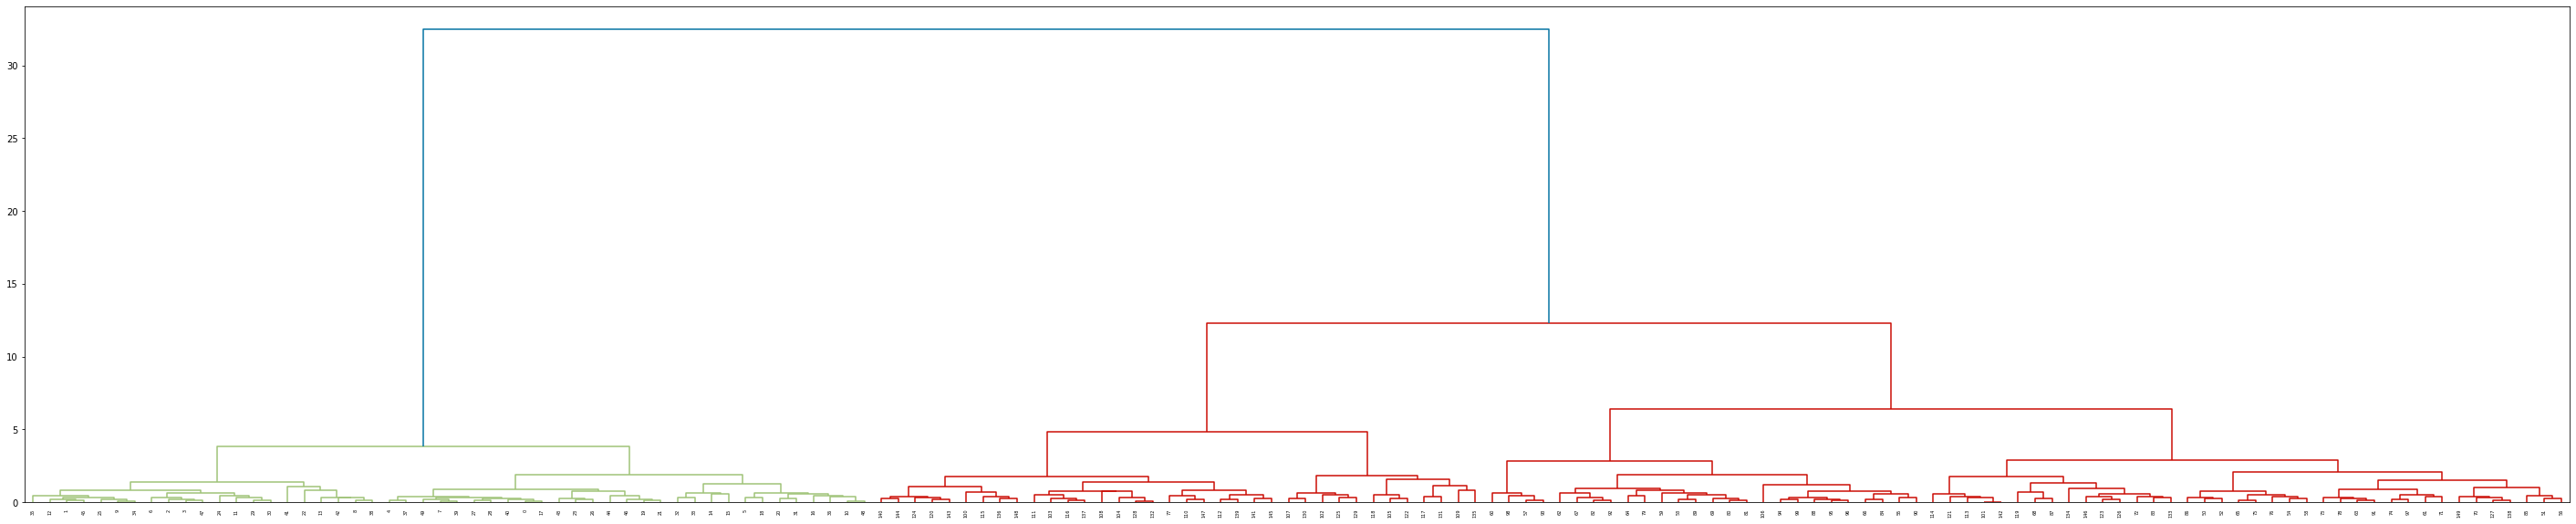

In [254]:
plt.figure(figsize=(50, 10))
x_linkage = ward(x)
dendrogram(x_linkage)
plt.show()

In [256]:
aggModel = AgglomerativeClustering(n_clusters=3, linkage='ward', affinity='euclidean').fit(x)

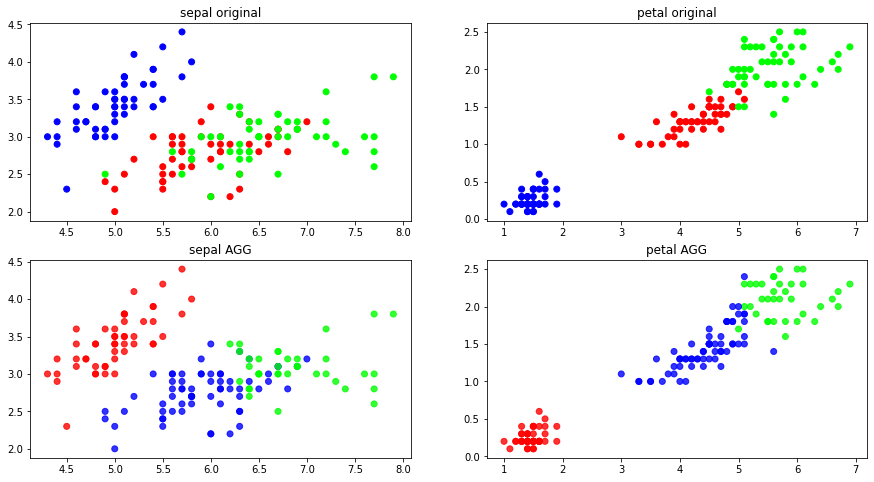

In [257]:
plt.figure( figsize=(15,8) )

plt.subplot(2, 2, 1)
plt.scatter( x[:, 0], x[:, 1], c=y, cmap='brg')
plt.title('sepal original')

plt.subplot(2, 2, 2)
plt.scatter( x[:, 2], x[:, 3], c=y, cmap='brg')
plt.title('petal original')

plt.subplot(2, 2, 3)
plt.scatter( x[:, 0], x[:, 1], c=aggModel.labels_, cmap='brg', alpha=0.8)
plt.title('sepal AGG')

plt.subplot(2, 2, 4)
plt.scatter( x[:, 2], x[:, 3], c=aggModel.labels_, cmap='brg', alpha=0.8)
plt.title('petal AGG')

plt.show()

### DBSCAN

In [258]:
dbscan = DBSCAN(eps=0.5, min_samples=10).fit(x)
db_labels = dbscan.fit_predict(x)

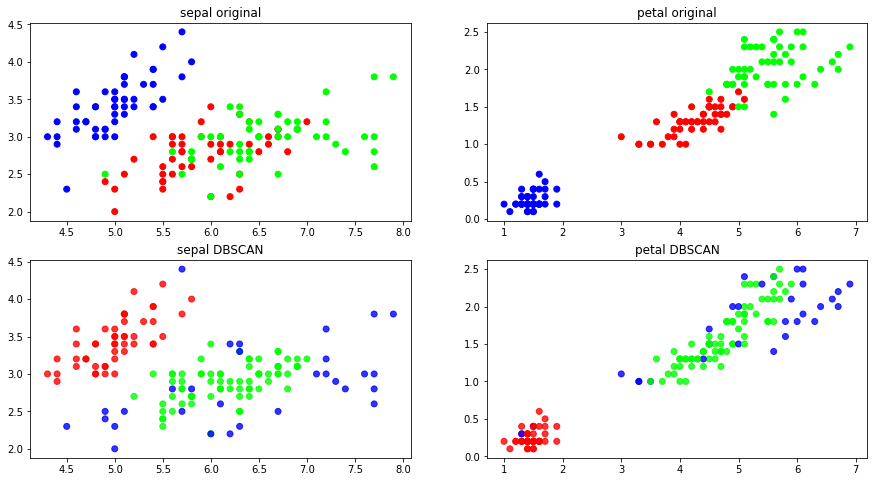

In [259]:
plt.figure( figsize=(15,8) )

plt.subplot(2, 2, 1)
plt.scatter( x[:, 0], x[:, 1], c=y, cmap='brg')
plt.title('sepal original')

plt.subplot(2, 2, 2)
plt.scatter( x[:, 2], x[:, 3], c=y, cmap='brg')
plt.title('petal original')

plt.subplot(2, 2, 3)
plt.scatter( x[:, 0], x[:, 1], c=db_labels, cmap='brg', alpha=0.8)
plt.title('sepal DBSCAN')

plt.subplot(2, 2, 4)
plt.scatter( x[:, 2], x[:, 3], c=db_labels, cmap='brg', alpha=0.8)
plt.title('petal DBSCAN')

plt.show()

## HDBSCAN

In [260]:
hdbModel = HDBSCAN( min_cluster_size=5 ).fit(x)
hdb_labels = hdbModel.fit_predict(x)

In [261]:
hdbModel = HDBSCAN(min_cluster_size=3, cluster_selection_epsilon=0.9, min_samples=3).fit(x)
hdb_labels = hdbModel.fit_predict(x)

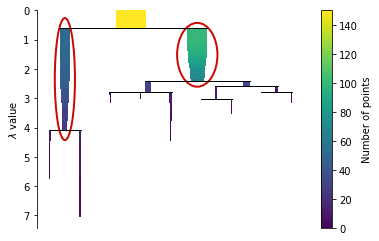

In [262]:
hdbModel.condensed_tree_.plot(select_clusters=True)
plt.show()

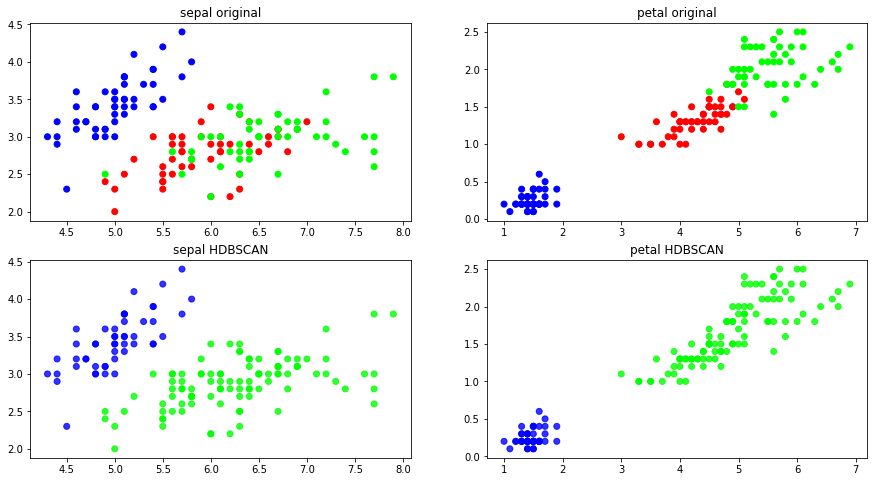

In [263]:
plt.figure( figsize=(15,8) )

plt.subplot(2, 2, 1)
plt.scatter( x[:, 0], x[:, 1], c=y, cmap='brg')
plt.title('sepal original')

plt.subplot(2, 2, 2)
plt.scatter( x[:, 2], x[:, 3], c=y, cmap='brg')
plt.title('petal original')

plt.subplot(2, 2, 3)
plt.scatter( x[:, 0], x[:, 1], c=hdb_labels, cmap='brg', alpha=0.8)
plt.title('sepal HDBSCAN')

plt.subplot(2, 2, 4)
plt.scatter( x[:, 2], x[:, 3], c=hdb_labels, cmap='brg', alpha=0.8)
plt.title('petal HDBSCAN')

plt.show()